## Employee Turnover/Churn

Dataset Source: https://www.kaggle.com/datasets/marikastewart/employee-turnover

#### Import Necessary Libraries

In [169]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import XGBClassifier

#### Show Library Versions

In [111]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print('XGBoost :'.rjust(n), xgb.__version__)
print("Imblearn :".rjust(n), imblearn.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.9.12
           NumPy : 1.24.3
          Pandas : 2.0.1
         Sklearn : 1.2.2
         XGBoost : 1.7.5
        Imblearn : 0.10.1
         Seaborn : 0.12.2


### Initial Data Preprocessing

#### Ingest Dataset

In [112]:
col_names = ["department",
             "promoted", 
             "review", 
             "projects",
             "salary", 
             "tenure", 
             "satisfaction",
             "bonus", 
             "avg_hrs_month", 
             "label"]

dtypes = {"department": str,
          "promoted": np.float64, 
          "review": np.float64, 
          "projects": np.float64,
          "salary": str, 
          "tenure": np.float64, 
          "satisfaction": np.float64,
          "bonus": np.float16, 
          "avg_hrs_month": np.float64, 
          "label": str}

data = pd.read_csv("employee_churn_data.csv",
                   names=col_names, 
                   dtype=dtypes,
                   engine='c',
                   header=0)

data = data.fillna(-1)

data.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,label
0,operations,0.0,0.577569,3.0,low,5.0,0.626759,0.0,180.866070,no
1,operations,0.0,0.751900,3.0,medium,6.0,0.443679,0.0,182.708149,no
2,support,0.0,0.722548,3.0,medium,6.0,0.446823,0.0,184.416084,no
3,logistics,0.0,0.675158,4.0,high,8.0,0.440139,0.0,188.707545,no
4,sales,0.0,0.676203,3.0,high,5.0,0.577607,1.0,179.821083,no


#### More Dataset Information

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   float64
 2   review         9540 non-null   float64
 3   projects       9540 non-null   float64
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   float16
 8   avg_hrs_month  9540 non-null   float64
 9   label          9540 non-null   object 
dtypes: float16(1), float64(6), object(3)
memory usage: 689.5+ KB


### Visualizations

#### Create Function to Visualize Features (Histograms)

In [114]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at 
    a specified value instead of the automatically generated 
    value, assign the float value here. Otherwise, the 
    autogenerated start value will be used.
    - y_label: The string label value for the y label.
    
    Output:
    - A histogram.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."
    
    ax = feature_to_visualize.hist(grid=False, 
                                   bins=num_of_bins, 
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Review

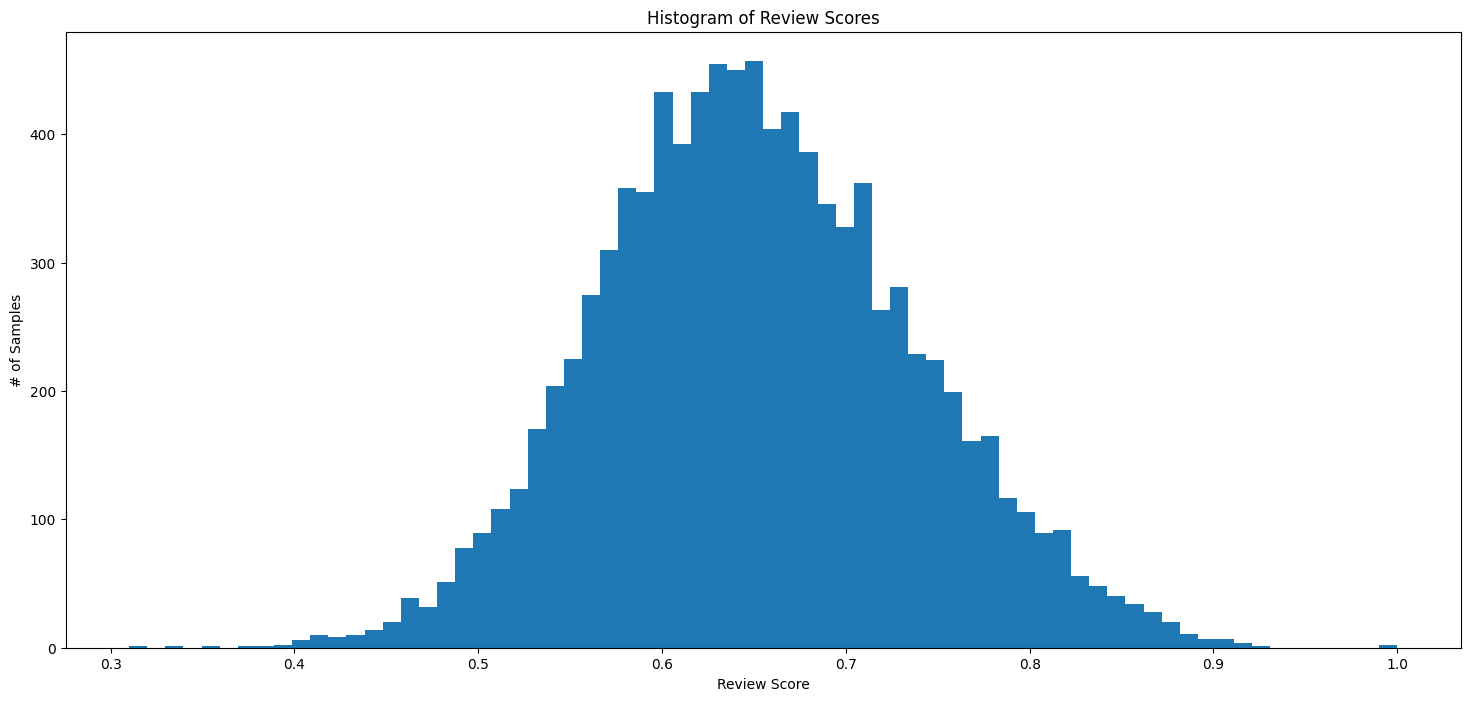

The Review Scores range is 0.31 to 1.0.


In [115]:
histogram_visual(data['review'],
                 num_of_bins=70,
                 plot_title="Histogram of Review Scores",
                 x_label="Review Score")

print(f"The Review Scores range is {min(data['review'])} to" + 
      f" {max(data['review'])}.")

#### Dataset Visualization: Tenure

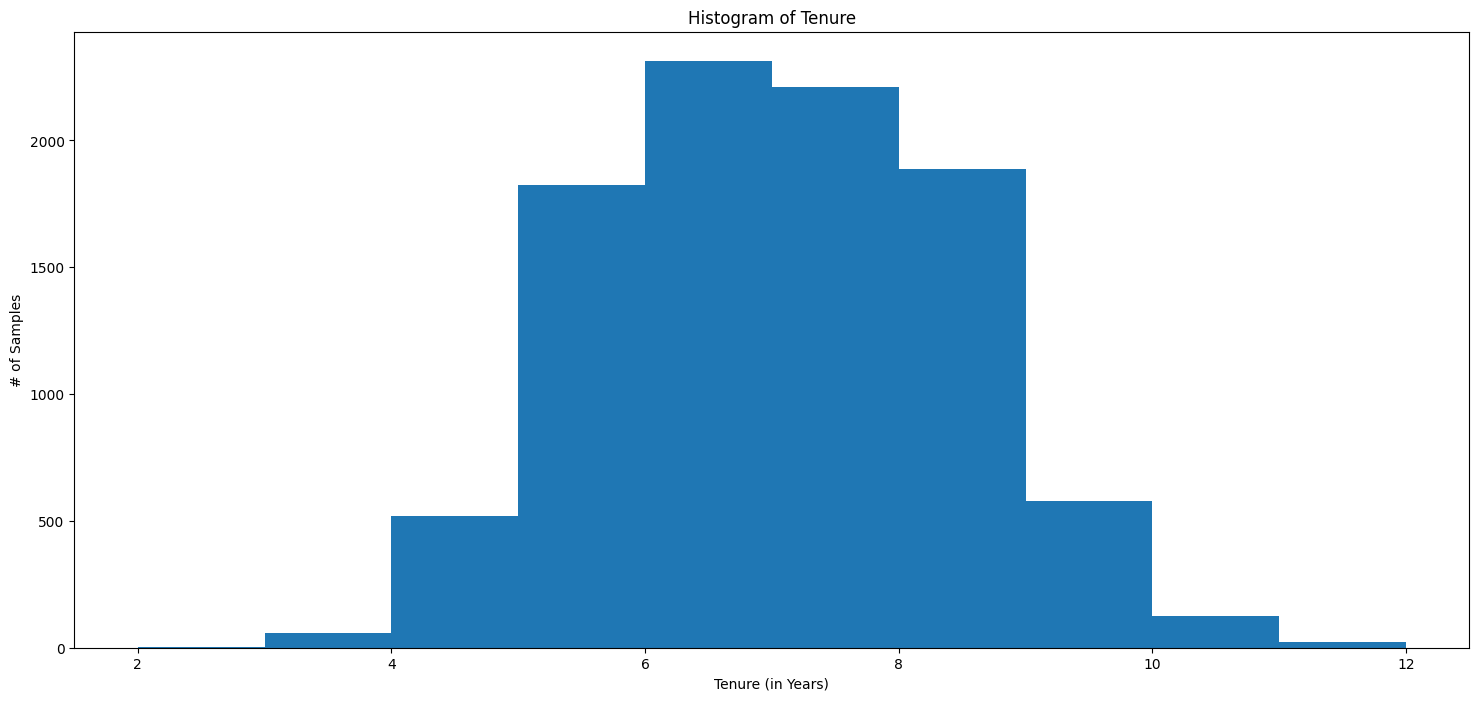

The tenure range is 2.0 to 12.0 years.


In [116]:
histogram_visual(data['tenure'],
                 num_of_bins=10,
                 plot_title="Histogram of Tenure",
                 x_label="Tenure (in Years)")

print(f"The tenure range is {min(data['tenure'])} to" + 
      f" {max(data['tenure'])} years.")

#### Dataset Visualization: Satisfaction

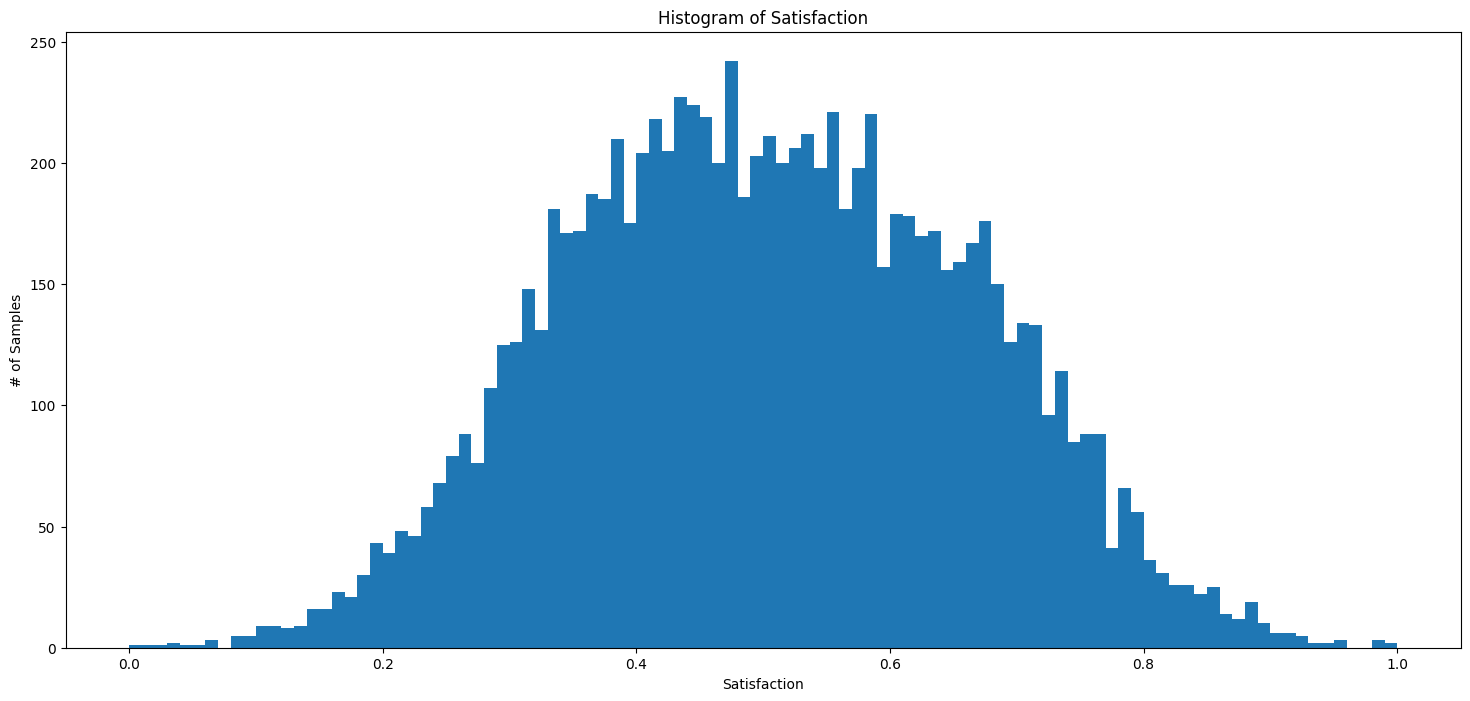

The satisfaction range (from surveys) was 0.0 to 1.0000000000000002.


In [117]:
histogram_visual(data['satisfaction'],
                 num_of_bins=100,
                 plot_title="Histogram of Satisfaction",
                 x_label="Satisfaction")

print(f"The satisfaction range (from surveys) was {min(data['satisfaction'])} to" + 
      f" {max(data['satisfaction'])}.")

#### Dataset Visualization: Average Hours Per Month

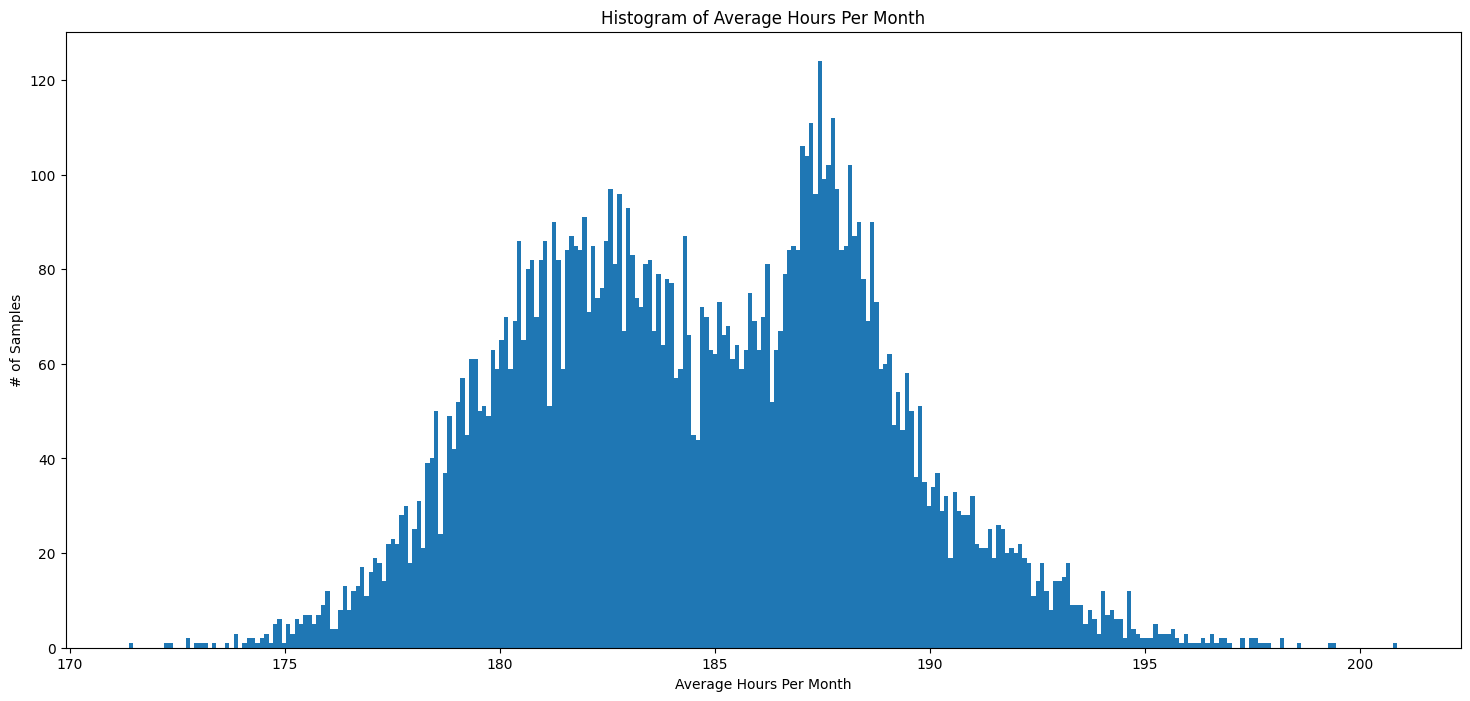

The average number of hours worked ranged from 171.37406048199938 to 200.8616558715116.


In [118]:
histogram_visual(data['avg_hrs_month'],
                 num_of_bins=291,
                 plot_title="Histogram of Average Hours Per Month",
                 x_label="Average Hours Per Month")

print(f"The average number of hours worked ranged" +
      f" from {min(data['avg_hrs_month'])}" + 
      f" to {max(data['avg_hrs_month'])}.")

#### Create Function to Visualize Features (Barplot)

In [119]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
        
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(12,8),
                                                      rot=0, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red",
                                                             "purple"]
                                                      )
    
    ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Dataset Visualization: Department That Employees Work in

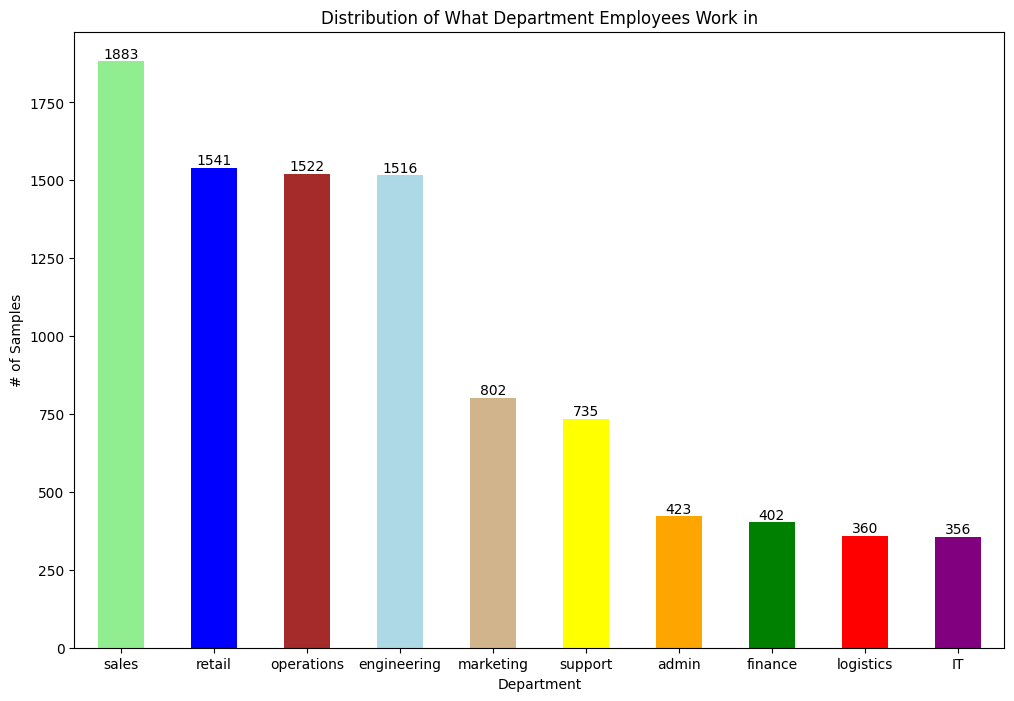

In [120]:
barplot_visual(data["department"],
               "Distribution of What Department Employees Work in",
               "Department",
               "# of Samples",
               )

#### Dataset Visualization: Projects

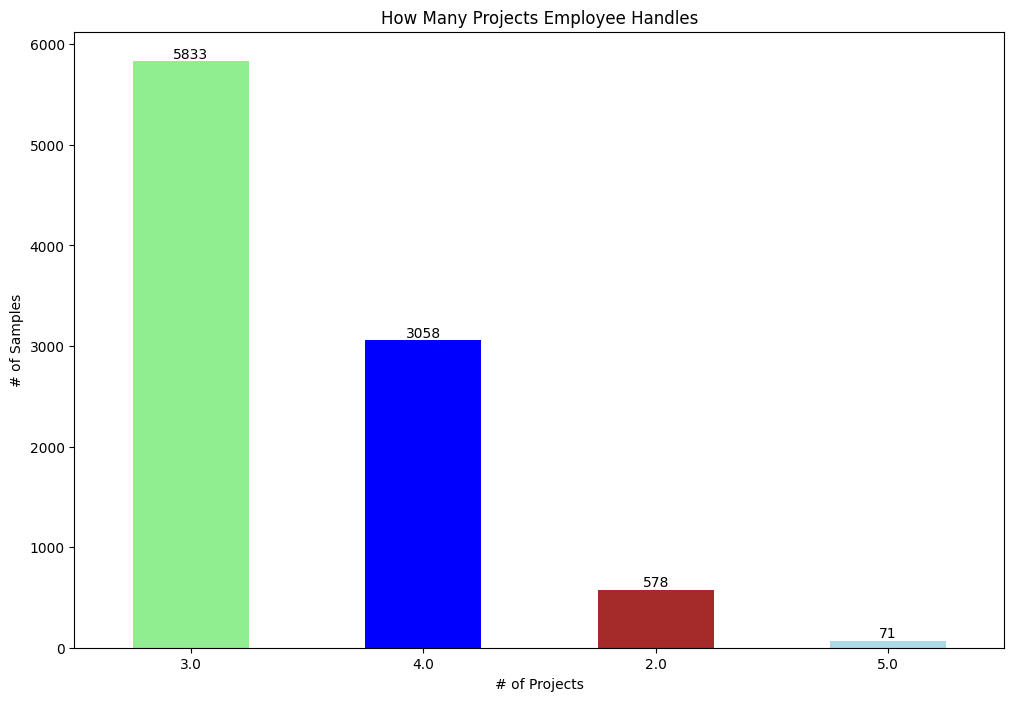

In [121]:
barplot_visual(data["projects"],
               "How Many Projects Employee Handles",
               "# of Projects",
               "# of Samples",
               )

#### Dataset Visualization: Salary

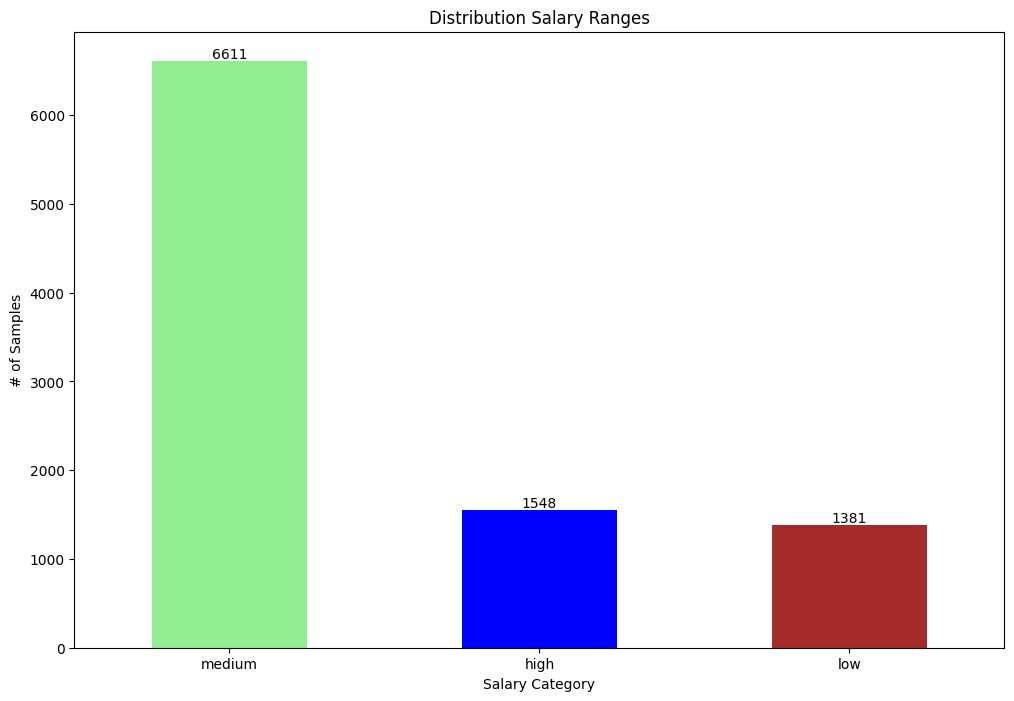

In [122]:
barplot_visual(data["salary"],
               "Distribution Salary Ranges",
               "Salary Category",
               "# of Samples",
               )

#### Dataset Visualization: Bonus

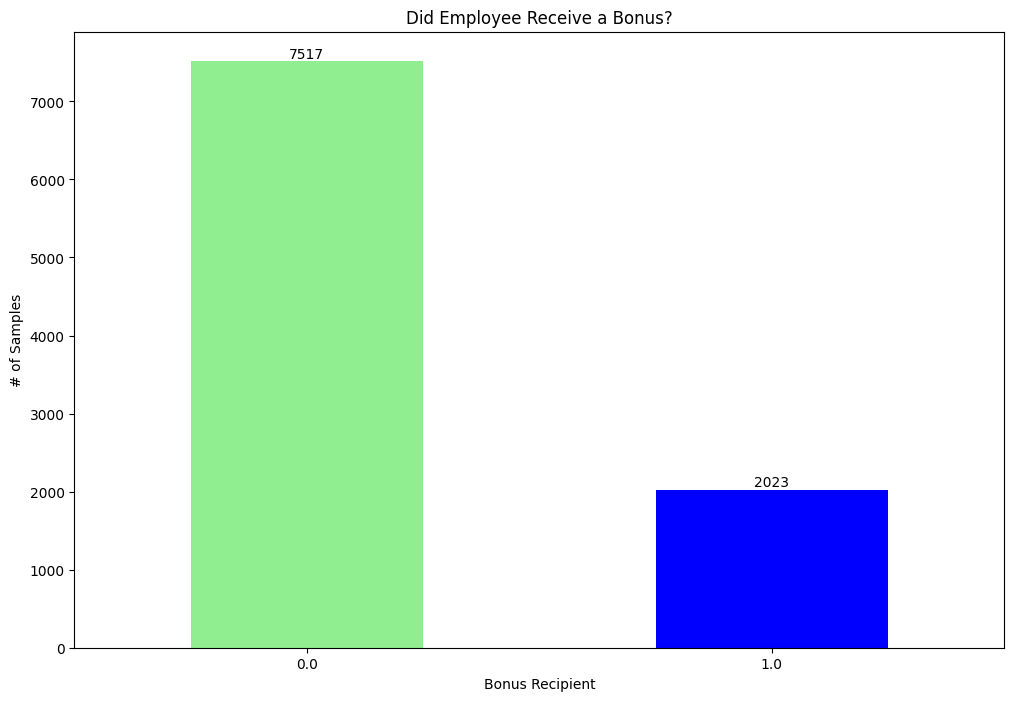

In [123]:
barplot_visual(data["bonus"],
               "Did Employee Receive a Bonus?",
               "Bonus Recipient",
               "# of Samples",
               )

#### Dataset Visualization: Class Distribution

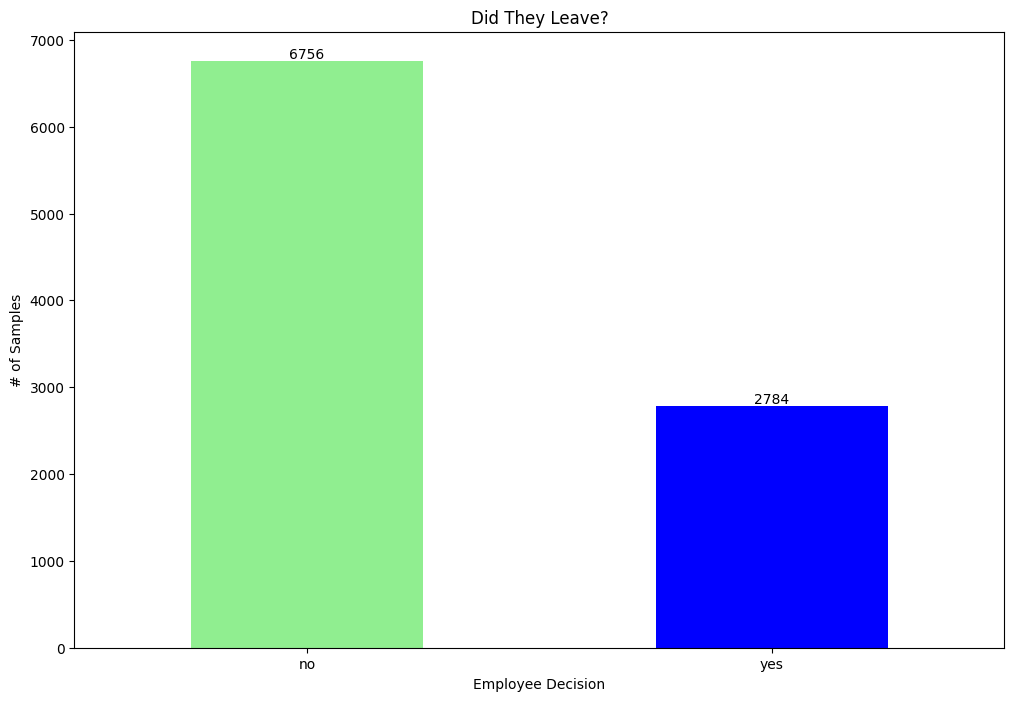

In [124]:
barplot_visual(data["label"],
               "Did They Leave?",
               "Employee Decision",
               "# of Samples",
               )

### Exploratory Data Analysis & Preprocessing

#### Descriptive Statistics

In [125]:
data.describe(percentiles=[0.01, 0.10, 0.25, 0.50, 0.75, 0.90,0.99], include='all')

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,label
count,9540,9540.000000,9540.000000,9540.000000,9540,9540.000000,9540.000000,9540.000000,9540.000000,9540
unique,10,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,2
top,sales,NaN,NaN,NaN,medium,NaN,NaN,NaN,NaN,no
freq,1883,NaN,NaN,NaN,6611,NaN,NaN,NaN,NaN,6756
mean,NaN,0.030294,0.651826,3.274843,NaN,6.556184,0.504645,0.212158,184.661571,NaN
std,NaN,0.171403,0.085307,0.579136,NaN,1.415432,0.158555,0.408936,4.144831,NaN
min,NaN,0.000000,0.310000,2.000000,NaN,2.000000,0.000000,0.000000,171.374060,NaN
1%,NaN,0.000000,0.461668,2.000000,NaN,4.000000,0.164069,0.000000,175.968689,NaN
10%,NaN,0.000000,0.546093,3.000000,NaN,5.000000,0.300923,0.000000,179.340896,NaN
25%,NaN,0.000000,0.592884,3.000000,NaN,5.000000,0.386801,0.000000,181.472085,NaN


#### Finish Preprocessing Dataset

In [126]:
data['label'] = data['label'].replace(
    {
        "no": 0.0, 
        "yes": 1.0
    }
    ).astype(np.float16)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   float64
 2   review         9540 non-null   float64
 3   projects       9540 non-null   float64
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   float16
 8   avg_hrs_month  9540 non-null   float64
 9   label          9540 non-null   float16
dtypes: float16(2), float64(6), object(2)
memory usage: 633.6+ KB


### Prepare Shared Pipeline Data & Stages/Steps

#### Split Dataset into Training & Testing Datasets

In [127]:
y = data['label']
X = data.drop(columns=['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

print(f"Training Inputs Dataset Shape: {X_train.shape}")
print(f"Training Outputs Dataset Shape: {y_train.shape}\n")
print(f"Testing Inputs Dataset Shape: {X_test.shape}")
print(f"Testing Outputs Dataset Shape: {y_test.shape}")

Training Inputs Dataset Shape: (7632, 9)
Training Outputs Dataset Shape: (7632,)

Testing Inputs Dataset Shape: (1908, 9)
Testing Outputs Dataset Shape: (1908,)


#### Define Column Lists for Transformers (Pipeline Stages) & Transform to Integer Values

In [128]:
features_to_remove_outliers = ["review", 
                               "satisfaction", 
                               "avg_hrs_month"]

ord_features = ["tenure", 
                "salary"]

nom_features = ["department"]

#### Remove Outliers

In [129]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, features_to_remove):
    df = pd.DataFrame(df).copy()
    for feat in features_to_remove:
        x = df[feat]
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3-q1
        ul = q3 + (iqr * 1.5)
        ll = q1 - (iqr * 1.5)
        neo_df = df[(df[feat] >= ll) | (df[feat] <= ul)]
    return neo_df

outlier_remover = FunctionTransformer(remove_outliers, 
                                      kw_args={
                                          'features_to_remove': features_to_remove_outliers
                                          }
                                      )

#### Create Column Transformer

In [130]:
encoder_col_transformer = ColumnTransformer(
    [
        (
            "remove_outliers",
            outlier_remover,
            features_to_remove_outliers
        ),
        (
            'ord_encoder', 
            OrdinalEncoder(handle_unknown='use_encoded_value', 
                           unknown_value=-1,
                           dtype=np.float64), 
            ord_features
            ), 
        (
            'ohe', 
            OneHotEncoder(handle_unknown='ignore',
                          dtype=np.float64), 
            nom_features)
    ], 
    remainder='passthrough')

#### Metrics Evaluation Method

In [131]:
def metrics_evaluation(classifier_type,
                       y_test, 
                       y_pred_cv):
    
    
    print("+-------------------------------------------------------------------------+")
    print(f"\tConfusion Matrix for {classifier_type}")
    print("+-------------------------------------------------------------------------+")
    
    cm = confusion_matrix(y_test, 
                          y_pred_cv)

    display_cm = ConfusionMatrixDisplay(cm, 
                                        display_labels=[
                                            "Stayed", 
                                            "Left"
                                            ]
                                        )

    display_cm.plot()
    plt.show()
    
    print("+-----------------------------------------------------+")
    print(f"\tClassification Report for {classifier_type}")
    print("+-----------------------------------------------------+")
    
    print(classification_report(y_test, 
                                y_pred_cv, 
                                target_names=[
                                    "Stayed", 
                                    "Left"]
                                )
          )

### Random Forest Classifier

#### Define Pipeline

In [132]:
def random_forest_classifier():
    """
    This function creates the random forest classifier.
    """
    random_forest_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()),
            (
                'random_forest', 
                RandomForestClassifier(criterion="entropy",
                                       n_estimators=200,
                                       random_state=42)
             ),
        ]
        )
    
    return random_forest_pipe

#### Define Model

In [133]:
rfc = random_forest_classifier()

rfc.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit Dataset to Random Forest Classifier

In [134]:
y_pred_cv = cross_val_predict(rfc, 
                              X_train, 
                              y_train, 
                              cv=10)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for Random Forest
+-------------------------------------------------------------------------+


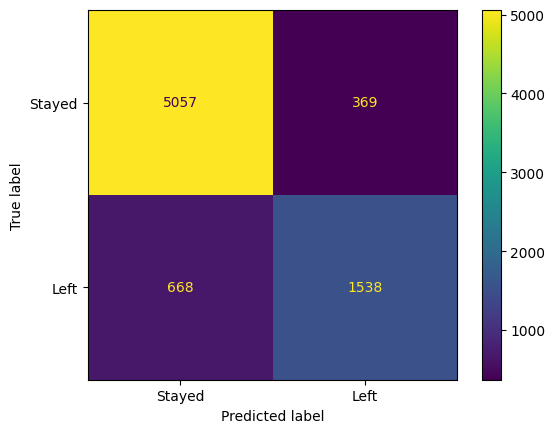

+-----------------------------------------------------+
	Classification Report for Random Forest
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.88      0.93      0.91      5426
        Left       0.81      0.70      0.75      2206

    accuracy                           0.86      7632
   macro avg       0.84      0.81      0.83      7632
weighted avg       0.86      0.86      0.86      7632



In [135]:
metrics_evaluation("Random Forest", 
                       y_train, 
                       y_pred_cv)

### Naive Bayes Classifier

#### Define Pipeline

In [136]:
def naive_bayes_classifier():
    """
    This function creates the naive bayes classifier.
    """
    naive_bayes_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                'smote',
                SMOTE(random_state=42, sampling_strategy='all')),
            (
                'scaler', 
                MinMaxScaler(),
            ),
            (
                'naive_bayes', 
                MultinomialNB()
             ),
        ]
        )
    
    return naive_bayes_pipe

#### Fit Model

In [137]:
nbc = naive_bayes_classifier()

nbc.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit Naive Bayes Classifier to Dataset

In [138]:
y_pred_cv = cross_val_predict(nbc, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for Naive Bayes
+-------------------------------------------------------------------------+


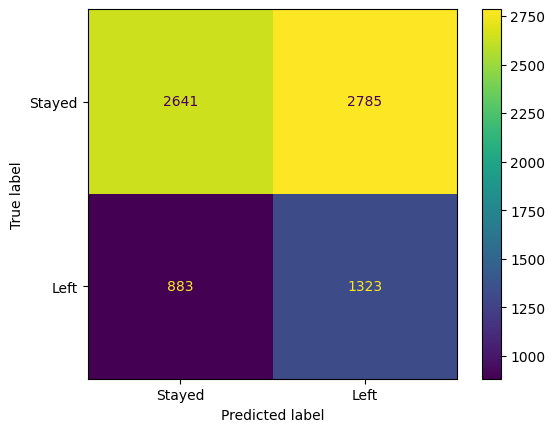

+-----------------------------------------------------+
	Classification Report for Naive Bayes
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.75      0.49      0.59      5426
        Left       0.32      0.60      0.42      2206

    accuracy                           0.52      7632
   macro avg       0.54      0.54      0.50      7632
weighted avg       0.63      0.52      0.54      7632



In [139]:
metrics_evaluation("Naive Bayes", 
                       y_train, 
                       y_pred_cv)

### Logistic Regression Classifier

#### Define Pipeline

In [140]:
def logistic_regression_classifier():
    """
    This function creates the logistic regression classifier.
    """
    log_reg_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()),
            (
                'smote',
                SMOTE(random_state=42, sampling_strategy='all')),
            (
                'log_reg', 
                LogisticRegression(solver='newton-cholesky', 
                                   max_iter=300,
                                   penalty='l2',
                                   C=0.95,
                                   n_jobs=-1)
             ),
        ]
        )
    
    return log_reg_pipe

#### Fit Model

In [141]:
log_reg = logistic_regression_classifier()

log_reg.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit Logistic Regression Classifier to Dataset

In [142]:
y_pred_cv = cross_val_predict(log_reg, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for Logistic Regression
+-------------------------------------------------------------------------+


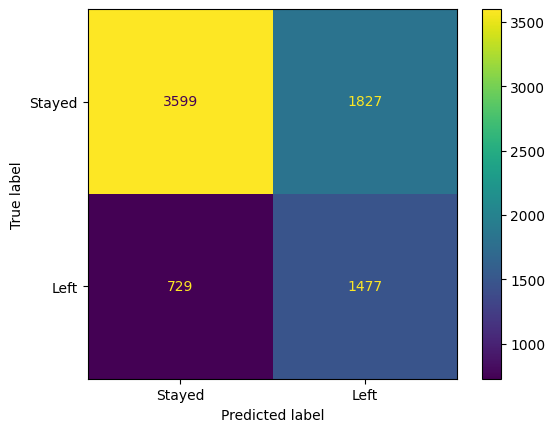

+-----------------------------------------------------+
	Classification Report for Logistic Regression
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.83      0.66      0.74      5426
        Left       0.45      0.67      0.54      2206

    accuracy                           0.67      7632
   macro avg       0.64      0.67      0.64      7632
weighted avg       0.72      0.67      0.68      7632



In [143]:
metrics_evaluation("Logistic Regression", 
                       y_train, 
                       y_pred_cv)

### K-Nearest Neighbors Classifier

#### Define KNN Pipeline

In [144]:
def knn_classifier():
    """
    This function creates the K-Nearest Neighbors classifier.
    """
    knn_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'smote',
                SMOTE(random_state=42, sampling_strategy='all')),
            (
                'knn_clf', 
                KNeighborsClassifier(weights='distance',
                                     p=1,
                                     n_neighbors=3)
             ),
        ]
        )
    
    return knn_pipe

#### Fit Model

In [145]:
knn_clf = knn_classifier()

knn_clf.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit KNN Classifier to Dataset

In [146]:
y_pred_cv = cross_val_predict(knn_clf, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for K-Nearest Neighbors
+-------------------------------------------------------------------------+


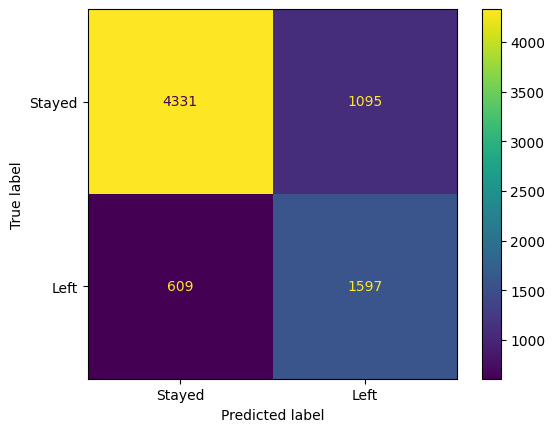

+-----------------------------------------------------+
	Classification Report for K-Nearest Neighbors
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.88      0.80      0.84      5426
        Left       0.59      0.72      0.65      2206

    accuracy                           0.78      7632
   macro avg       0.73      0.76      0.74      7632
weighted avg       0.79      0.78      0.78      7632



In [147]:
metrics_evaluation("K-Nearest Neighbors", 
                       y_train, 
                       y_pred_cv)

### Single Vector Machine (SVM) Classifier

#### Define Pipeline

In [148]:
def single_vector_machine_classifier():
    """
    This function creates the Single Vector Machine classifier.
    """
    svm_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()),
            (
                'smote',
                SMOTE(random_state=42, 
                      sampling_strategy='all')),
            (
                'svm', 
                SVC(kernel='linear', 
                    random_state=42, 
                    verbose=True)
             ),
        ]
        )
    
    return svm_pipe

#### Define Model

In [149]:
svm = single_vector_machine_classifier()

svm.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit Classifier to Dataset

In [150]:
y_pred_cv = cross_val_predict(svm, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM].......................................................................................................................................................................*.............*.............................*....*.........*..........*..................*.........*..................................*....*.......*.....*................................................*
optimization finished, #iter = 83551
obj = -7220.352047, rho = -0.138004
nSV = 7234, nBSV = 7213
Total nSV = 7234
..................................*........................*.*
optimization finished, #iter = 102520
obj = -7217.140699, rho = -0.134964
nSV = 7228, nBSV = 7207
Total nSV = 7228
...............................................*................*
optimization finished, #iter = 99536
.obj = -7283.768707, rho = -0.128927
nSV = 7296, nBSV = 7274
Total nSV = 7296
.........*................................*.......................................*.........

#### Evaluation Metrics

+-------------------------------------------------------------------------+
	Confusion Matrix for Single Vector Machine
+-------------------------------------------------------------------------+


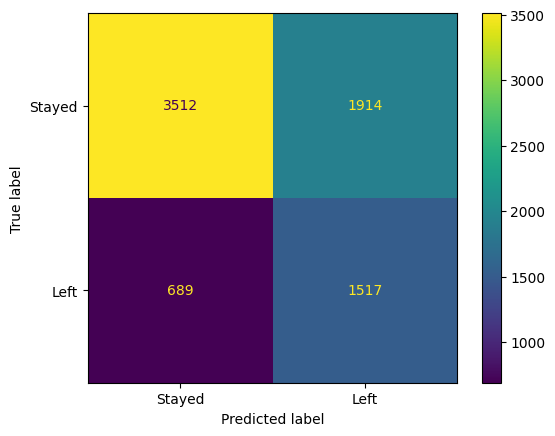

+-----------------------------------------------------+
	Classification Report for Single Vector Machine
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.84      0.65      0.73      5426
        Left       0.44      0.69      0.54      2206

    accuracy                           0.66      7632
   macro avg       0.64      0.67      0.63      7632
weighted avg       0.72      0.66      0.67      7632



In [151]:
metrics_evaluation("Single Vector Machine", 
                       y_train, 
                       y_pred_cv)

### Gradient Boosting Classifier Classifier

#### Parameters for Gradient Bossting Classifier

In [152]:
params = {'booster':'dart',
          'use_label_encoder': False,
          'n_estimators':125,
          'reg_alpha':0.10,
          'reg_lambda':0.10,
          'learning_rate':0.125,
          'random_state':42,
          'tree_method':'approx', 
          'eval_metric':['error'],
          'objective':'binary:logistic'}

#### Define Pipeline

In [153]:
def gradient_boosted_classifier(params):
    """
    This function creates 
    gradient boosting classifier.
    """
    xgb_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                'xgb_clf', 
                XGBClassifier(**params)
             ),
        ])
    
    return xgb_pipe

#### Fit Model

In [154]:
xgbc = gradient_boosted_classifier(params)

xgbc.named_steps

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7fccaa299ee0>,
                                                      kw_args={'features_to_remove': ['review',
                                                                                      'satisfaction',
                                                                                      'avg_hrs_month']}),
                                  ['review', 'satisfaction', 'avg_hrs_month']),
                                 ('ord_encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  ['tenure', 'salary']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['departme

#### Fit Classifier to Training Data 

In [155]:
y_pred_cv = cross_val_predict(xgbc, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for XGBoost
+-------------------------------------------------------------------------+


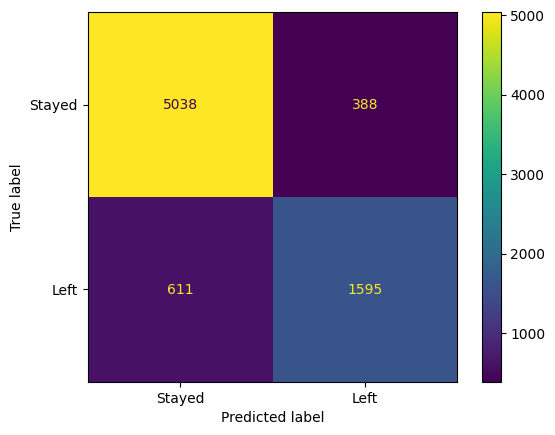

+-----------------------------------------------------+
	Classification Report for XGBoost
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.89      0.93      0.91      5426
        Left       0.80      0.72      0.76      2206

    accuracy                           0.87      7632
   macro avg       0.85      0.83      0.84      7632
weighted avg       0.87      0.87      0.87      7632



In [156]:
metrics_evaluation("XGBoost", 
                       y_train, 
                       y_pred_cv)

### Stacking Classifier (Random Forest, KNN, & SVM)

#### Define Estimators

In [157]:
estimators = [
    (
        'random_forest_clf',
        random_forest_classifier()
    ),
    (
        'knn_clf',
        knn_classifier()
    ),
    (
        'svm_clf',
        single_vector_machine_classifier()
    )
]

#### Define Model

In [158]:
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(),
    stack_method='predict',
    n_jobs=-1
)

#### Fit Classifier to Training Dataset

In [159]:
y_pred_cv = cross_val_predict(stacking_clf, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]........................................................................................................................................................*...........................*....................*......*..............*...*...................*....*....................................................................*......................................*.................*..................*..............................*.................*.......*
optimization finished, #iter = 102520
.*.obj = -7217.140699, rho = -0.134964
nSV = 7228, nBSV = 7207
Total nSV = 7228
.*............*
optimization finished, #iter = 83551
.obj = -7220.352047, rho = -0.138004
nSV = 7234, nBSV = 7213
Total nSV = 7234
.............................................*............................................................*..............................................*
optimization finished, #iter = 104232
*obj = -7283.957951, rho = -0.137796
n

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


......................*.................................*
optimization finished, #iter = 95260
obj = -5799.682196, rho = -0.128886
nSV = 5810, nBSV = 5792
Total nSV = 5810
....................................**..*.
optimization finished, #iter = 65439
obj = -5745.678028, rho = -0.156866
nSV = 5758, nBSV = 5735
Total nSV = 5758
...*......................................*...............*............*
optimization finished, #iter = 98550
.obj = -5858.358821, rho = -0.130273
nSV = 5868, nBSV = 5848
Total nSV = 5868
.....................................*..............*.*
optimization finished, #iter = 86882
obj = -5804.062908, rho = -0.146407
nSV = 5818, nBSV = 5793
Total nSV = 5818
..........................*..*..........................................*..............................*
optimization finished, #iter = 98814
obj = -5762.175360, rho = -0.144929
nSV = 5773, nBSV = 5753
Total nSV = 5773
....................*.....*..............*
optimization finished, #iter = 50792
obj = -5817.42

#### Confusion Matrix

+-------------------------------------------------------------------------+
	Confusion Matrix for Stacking Classifier
+-------------------------------------------------------------------------+


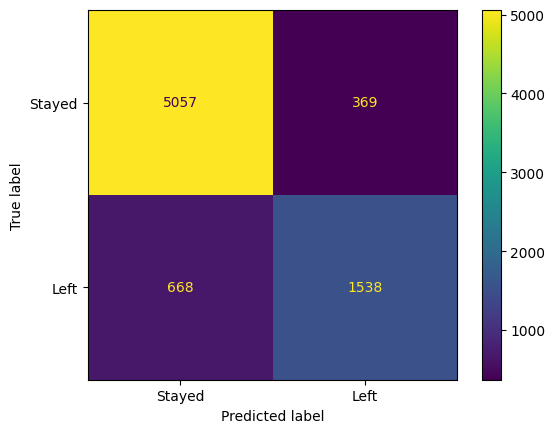

+-----------------------------------------------------+
	Classification Report for Stacking Classifier
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.88      0.93      0.91      5426
        Left       0.81      0.70      0.75      2206

    accuracy                           0.86      7632
   macro avg       0.84      0.81      0.83      7632
weighted avg       0.86      0.86      0.86      7632



In [160]:
metrics_evaluation("Stacking Classifier", 
                       y_train, 
                       y_pred_cv)

### Voting Classifier

#### Define Estimators

In [161]:
estimators = [
    (
        'random_forest_clf',
        random_forest_classifier()
    ),
    (
        'knn_clf',
        knn_classifier()
    ),
    (
        'svm_clf',
        single_vector_machine_classifier()
    )
]

#### Fit Model

In [166]:
voting_clf = VotingClassifier(
    estimators=estimators,
    #voting='soft',
    n_jobs=-1
)

#### Fit Classifier to Training Dataset

In [167]:
y_pred_cv = cross_val_predict(voting_clf, 
                              X_train, 
                              y_train, 
                              n_jobs=-1,
                              cv=10)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM].................................................................................................................................................................*...*..................................*..................**......*................*.............................*.......................................................*............................*.*
optimization finished, #iter = 102520
obj = -7217.140699, rho = -0.134964
nSV = 7228, nBSV = 7207
Total nSV = 7228
..............*........*.......................*.............................*.*
optimization finished, #iter = 83173
obj = -7259.650118, rho = -0.139133
nSV = 7273, nBSV = 7248
Total nSV = 7273
.......*..........................................*.............................................*.....................*....................**..*
optimization finished, #iter = 145964
obj = -7220.685888, rho = -0.147428
nSV = 7231, nBSV = 7211
Total nSV = 7231
...

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for Voting Classifier
+-------------------------------------------------------------------------+


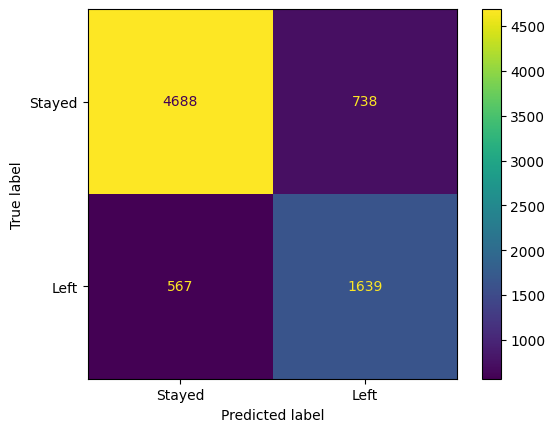

+-----------------------------------------------------+
	Classification Report for Voting Classifier
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Stayed       0.89      0.86      0.88      5426
        Left       0.69      0.74      0.72      2206

    accuracy                           0.83      7632
   macro avg       0.79      0.80      0.80      7632
weighted avg       0.83      0.83      0.83      7632



In [168]:
metrics_evaluation("Voting Classifier", 
                       y_train, 
                       y_pred_cv)

### Notes & Other Takeaways From This Project
****
- Here is a list of all of the different classifiers included in this project as well as their weighted f1-score
    - Random Forest Classifier
        - Weighted F1-Score => 0.86
    - Naive Bayes Classifier
        - Weighted F1-Score => 0.54
    - Logistic Regression Classifier
        - Weighted F1-Score => 0.68
    - Single Vector Machine Classifier
        - Weighted F1-Score => 0.67
    - K-Nearest Neighbors Classifier
        - Weighted F1-Score => 0.78
    - Gradient Boosting Classifier
        - Weighted F1-Score => 0.87
    - Stacking Classifier (Random Forest, KNN, & SVM with XGB Classifier as the final classifier)
        - Weighted F1-Score => 0.86
    - Voting Classifier (Random Forest, KNN, & SVM)
        - Weighted F1-Score => 0.83
- I always enjoy when new projects force me to learn something new. What I learned while completing this project includes:
    - I learned how to add a custom pipeline stage (the function to remove outliers). 
    - I added both the Stacking and Voting Classifiers to my repertoire.
****